<a href="https://colab.research.google.com/github/yugasaimanikanta0313/Simple/blob/main/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install tensorflow


In [3]:
pip install pandas numpy matplotlib seaborn scikit-learn


<ipython-input-5-83b3182edce5>:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df_power["Global_active_power"].resample("H").mean().fillna(method="ffill")
<ipython-input-5-83b3182edce5>:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_resampled = df_power["Global_active_power"].resample("H").mean().fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.0159 - val_loss: 0.0068
Epoch 2/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 0.0098 - val_loss: 0.0065
Epoch 3/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 0.0094 - val_loss: 0.0064
Epoch 4/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 0.0090 - val_loss: 0.0066
Epoch 5/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - loss: 0.0091 - val_loss: 0.0062
Epoch 6/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - loss: 0.0087 - val_loss: 0.0061
Epoch 7/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - loss: 0.0088 - val_loss: 0.0062
Epoch 8/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - loss: 0.0087 - val_loss: 0.0063
Epoch 9/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 0.0090 - val_loss: 0.0061
Epoch 10/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 0.0086 - val_loss: 0.0060
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


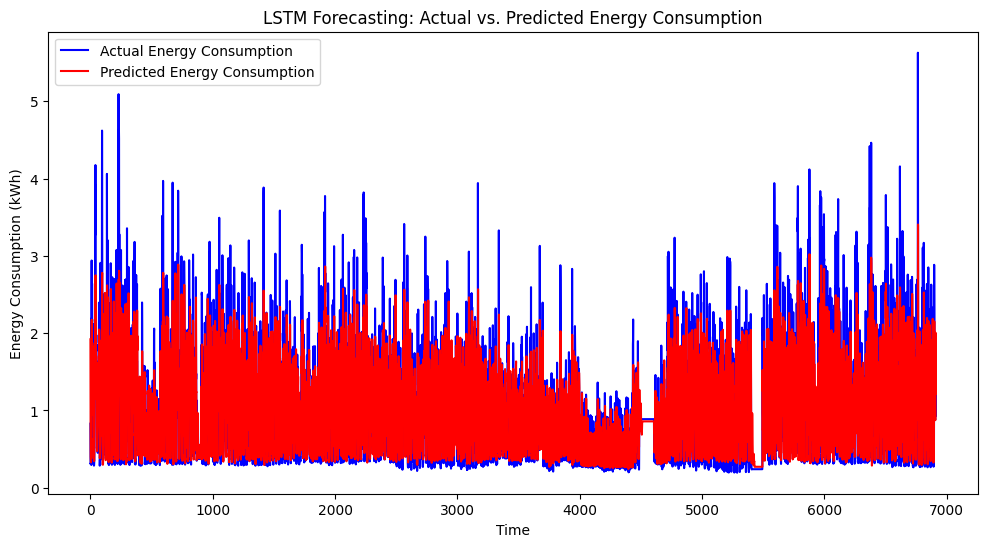

(0.3341139689329644, np.float64(0.49863175888178235))

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

file_path = "/mnt/data/household_power_consumption.csv"
df_power = pd.read_csv(file_path, sep=';', low_memory=False, na_values=['?'])

df_power["Datetime"] = pd.to_datetime(df_power["Date"] + " " + df_power["Time"], format="%d/%m/%Y %H:%M:%S")

df_power.set_index("Datetime", inplace=True)
df_power.sort_index(inplace=True)

df_power["Global_active_power"] = pd.to_numeric(df_power["Global_active_power"], errors="coerce")
df_power.dropna(inplace=True)

df_resampled = df_power["Global_active_power"].resample("H").mean().fillna(method="ffill")

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_resampled.values.reshape(-1, 1))

# Create sequences for LSTM model (time steps = 24 for daily forecasting)
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Create input sequences
time_steps = 24
X, y = create_sequences(scaled_data, time_steps)

# Split into training (80%) and testing (20%) sets
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape X for LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(1)  # Output layer
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions back to original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate model performance
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Energy Consumption", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Energy Consumption", color="red")
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.title("LSTM Forecasting: Actual vs. Predicted Energy Consumption")
plt.legend()
plt.show()

model.save("/mnt/data/lstm_energy_forecasting.h5")

mae, rmse
